## React Agent (推理-行动代理)

在这个notebook中，我们将学习React Agent的概念和实现。React Agent是一种基于ReAct (Reasoning and Acting) 范式的AI代理，它能够在解决问题时交替进行推理和行动。

### 什么是React Agent？

React Agent是一种AI代理架构，它遵循ReAct范式：
- **Reasoning (推理)**：代理分析问题，思考下一步应该采取什么行动
- **Acting (行动)**：代理执行具体的工具调用或输出最终答案
- **Observation (观察)**：代理观察行动的结果，并基于此进行下一轮推理

这种循环过程让AI能够：
1. 分解复杂问题
2. 逐步解决子问题
3. 根据中间结果调整策略
4. 最终达到目标

### React Agent vs 普通Tool Calling的区别

- **普通Tool Calling**：直接调用工具，获得结果后给出最终答案
- **React Agent**：在每次工具调用前进行推理，在获得结果后继续推理，可能进行多轮工具调用

React Agent特别适合需要多步推理和复杂问题解决的场景。


In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
import os
import subprocess
import dotenv

dotenv.load_dotenv()

model = ChatOpenAI(model="gpt-4.1", temperature=0)

os.makedirs("./temp", exist_ok=True)

@tool(parse_docstring=True)
def write_file(filename: str, content: str) -> str:
    """写入文件到temp目录，系统自动拼接 "./temp/" 前缀, 例如 filename="test.txt" 则实际写入 "./temp/test.txt"

    Args:
        filename: 文件名
        content: 文件内容

    Returns:
        操作结果
    """
    try:
        filepath = os.path.join("./temp", filename)
        with open(filepath, "w", encoding="utf-8") as f:
            f.write(content)
        return f"文件已成功写入: {filepath}"
    except Exception as e:
        return f"写入文件失败: {str(e)}"

@tool(parse_docstring=True)
def run_python_file(filename: str) -> str:
    """运行temp目录下的Python文件，系统自动拼接 "./temp/" 前缀, 例如 filename="test.py" 则实际运行 "./temp/test.py"

    Args:
        filename: 文件名

    Returns:
        执行结果
    """
    try:
        filepath = os.path.join("./temp", filename)
        if not os.path.exists(filepath):
            return f"文件不存在: {filepath}"
        
        result = subprocess.run(
            ["python3", filepath], 
            capture_output=True, 
            text=True,
            cwd="./temp"
        )
        
        output = ""
        if result.stdout:
            output += f"输出:\n{result.stdout}\n"
        if result.stderr:
            output += f"错误:\n{result.stderr}\n"
        if result.returncode != 0:
            output += f"返回码: {result.returncode}\n"
            
        return output if output else "程序运行完成，无输出"
    except Exception as e:
        return f"运行Python文件失败: {str(e)}"

tools = [write_file, run_python_file]

print("React Agent环境设置完成")


React Agent环境设置完成


### React Agent的两种实现方式

为了演示Reasoning和Acting的区别，我们将实现两种不同的React Agent：

#### 方式一：只输出工具调用（Acting Only）
这种方式让模型直接输出工具调用，不包含推理过程。类似于传统的function calling。

#### 方式二：先推理再行动（Reasoning + Acting）
这种方式要求模型在每次工具调用前明确表达自己的思考过程，然后再执行相应的行动。

这两种方式的主要区别：
- **性能差异**：方式一更快，方式二更慢但更可解释
- **可解释性**：方式二提供了完整的推理过程
- **调试友好性**：方式二便于理解AI的决策过程
- **适用场景**：方式一适合极其简单任务，方式二适合复杂推理任务

让我们用相同的任务来演示这两种方式的差异。


In [5]:
# 方式一：只输出工具调用（Acting Only）
system_prompt_acting = """
你是一个编程助手。用户会给你编程任务，你需要使用可用的工具来完成任务。

重要：只调用工具，不要输出任何解释性文本。直接使用工具来完成任务。
"""

user_task = "请写一个Python代码来验证一维Normal分布的最大似然估计(MLE)公式，使用模拟数据进行验证"

print(f"用户: {user_task}")

llm_with_tools = model.bind_tools(tools)
messages = [
    SystemMessage(content=system_prompt_acting),
    HumanMessage(content=user_task)
]

response = llm_with_tools.invoke(messages)
print(f"AI响应: {response}")

if hasattr(response, 'tool_calls') and response.tool_calls:
    print(f"AI调用工具: {[tc['name'] for tc in response.tool_calls]}")
    for tool_call in response.tool_calls:
        print(f"工具调用详情: {tool_call['name']} - {tool_call['args']}")
else:
    print("AI没有调用工具")


用户: 请写一个Python代码来验证一维Normal分布的最大似然估计(MLE)公式，使用模拟数据进行验证
AI响应: content='' additional_kwargs={'tool_calls': [{'id': 'call_OJwHIgvoNiTGJ5SVzf51NHwm', 'function': {'arguments': '{"filename":"mle_normal.py","content":"import numpy as np\\nfrom scipy.stats import norm\\n\\n# 生成模拟数据\\nnp.random.seed(0)\\ntrue_mu = 5.0\\ntrue_sigma = 2.0\\nn_samples = 1000\\ndata = np.random.normal(loc=true_mu, scale=true_sigma, size=n_samples)\\n\\n# MLE估计\\nmle_mu = np.mean(data)\\nmle_sigma = np.sqrt(np.mean((data - mle_mu) ** 2))\\n\\n# 使用scipy的fit方法进行对比\\nfit_mu, fit_sigma = norm.fit(data)\\n\\nprint(f\\"True mu: {true_mu}, True sigma: {true_sigma}\\")\\nprint(f\\"MLE mu: {mle_mu:.4f}, MLE sigma: {mle_sigma:.4f}\\")\\nprint(f\\"Scipy fit mu: {fit_mu:.4f}, fit sigma: {fit_sigma:.4f}\\")\\n"}', 'name': 'write_file'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 222, 'prompt_tokens': 157, 'total_tokens': 379, 'completion_tokens_details': {'accepted_prediction_

In [6]:
# 方式二：先推理再行动（Reasoning + Acting）  
system_prompt_reasoning = """
你是一个编程助手。用户会给你编程任务，你需要使用可用的工具来完成任务。

重要：在每次调用工具之前，你必须先明确说明：
1. 你的思考过程 (Thought)
2. 你计划采取的行动 (Action) 
3. 你期望的结果 (Expected Result)

请按照以下格式回应：
Thought: [你的思考过程]
Action: [你将要执行的行动]
Expected Result: [你期望得到的结果]

然后再调用相应的工具。
"""

print(f"用户: {user_task}")

messages = [
    SystemMessage(content=system_prompt_reasoning),
    HumanMessage(content=user_task)
]

response = llm_with_tools.invoke(messages)
print(f"AI响应: {response}")

if response.content:
    print(f"AI推理: {response.content}")
    
if hasattr(response, 'tool_calls') and response.tool_calls:
    print(f"AI调用工具: {[tc['name'] for tc in response.tool_calls]}")
    for tool_call in response.tool_calls:
        print(f"工具调用详情: {tool_call['name']} - {tool_call['args']}")
else:
    print("AI没有调用工具")


用户: 请写一个Python代码来验证一维Normal分布的最大似然估计(MLE)公式，使用模拟数据进行验证
AI响应: content='Thought:  \n要验证一维正态分布的最大似然估计（MLE）公式，我们需要：\n1. 生成一组服从已知均值和方差的正态分布的模拟数据。\n2. 用MLE公式计算均值和方差的估计值。\n3. 用numpy的mean和var函数进行对比，验证MLE公式的正确性。\n4. 输出真实参数、MLE估计值和numpy计算值。\n\n我将先写一个Python脚本来实现上述步骤。  \nAction:  \n准备写入一个Python文件，内容包括数据生成、MLE推导实现、对比和输出。  \nExpected Result:  \n生成一个Python脚本，能够输出真实参数、MLE估计值和numpy计算值，验证MLE公式的正确性。' additional_kwargs={'tool_calls': [{'id': 'call_ZBmI2JDx91e6Q8mlYlFw3l8m', 'function': {'arguments': '{"filename":"mle_normal_verify.py","content":"import numpy as np\\n\\n# 1. 生成模拟数据\\nnp.random.seed(42)\\ntrue_mu = 5.0\\ntrue_sigma = 2.0\\nn = 1000\\ndata = np.random.normal(loc=true_mu, scale=true_sigma, size=n)\\n\\n# 2. MLE公式\\n# MLE均值: mu_hat = sum(x_i)/n\\n# MLE方差: sigma2_hat = sum((x_i - mu_hat)^2)/n\\nmu_mle = np.sum(data) / n\\nsigma2_mle = np.sum((data - mu_mle) ** 2) / n\\n\\n# 3. numpy的mean和var（注意var默认是无偏估计，需要ddof=0才是MLE）\\nmu_np = np.mean(data)\\nsigma2_np = np.var(data, ddof=0)\\n\\n# 4. 输出结果\\n

### 两种方式的性能对比分析

通过上面的示例，我们可以观察到两种方式的差异：

#### 方式一（Acting Only）的特点：
- **速度快**：直接执行工具调用，减少了推理步骤
- **Token消耗少**：不需要生成额外的推理文本

#### 方式二（Reasoning + Acting, ReAct模式）的特点：
- **可解释性强**：能够清楚地看到AI的思考过程
- **调试友好**：便于理解每一步的决策逻辑
- **更适合复杂任务**：困难问题性能更高（为什么？因为更符合训练数据）
- **Token消耗多**：需要生成额外的推理文本
- **速度较慢**：需要额外的推理步骤

### 选择建议：
- **极其简单任务**：选择方式一（Acting Only）
- **复杂推理任务**：选择方式二（Reasoning + Acting）
- **开发调试**：建议使用方式二，便于问题排查
- **问题排查**: 现在ReAct模式几乎成为了模型的默认偏好，如果发现模型表现差，可以排查是否是因为模型选择了模式一




接下来我们将展示如何使用LangGraph来实现更强大和灵活的React Agent。LangGraph提供了两种主要方式：

1. **使用预构建的create_react_agent**
2. **手动构建图结构**


In [11]:
from langgraph.prebuilt import create_react_agent

# 方式一：使用预构建的create_react_agent
agent = create_react_agent(
    model=model,
    tools=tools,
)

result = agent.invoke(
    {"messages": [
        HumanMessage(content=user_task+"调用工具直接为我完成这件事。")]}
)

# 打印对话历史
for message in result["messages"]:
    if hasattr(message, 'type'):
        if message.type == "human":
            print(f"用户: {message.content}")
        elif message.type == "ai":
            print(f"AI: {message.content}")
            if hasattr(message, 'tool_calls') and message.tool_calls:
                print(f"AI调用工具: {[tc['name'] for tc in message.tool_calls]}")
        elif message.type == "tool":
            print(f"工具结果: {message.content[:100]}...")  # 截断长输出
    else:
        print(f"消息: {message}")

用户: 请写一个Python代码来验证一维Normal分布的最大似然估计(MLE)公式，使用模拟数据进行验证调用工具直接为我完成这件事。
AI: 
AI调用工具: ['write_file']
工具结果: 文件已成功写入: ./temp/mle_normal.py...
AI: 
AI调用工具: ['run_python_file']
工具结果: 错误:
python3: can't open file '/Users/bytedance/Work/agents101/temp/./temp/mle_normal.py': [Errno 2] ...
AI: 
AI调用工具: ['write_file']
工具结果: 文件已成功写入: ./temp/mle_normal.py...
AI: 
AI调用工具: ['run_python_file']
工具结果: 错误:
python3: can't open file '/Users/bytedance/Work/agents101/temp/./temp/mle_normal.py': [Errno 2] ...
AI: 出现了路径问题，导致代码无法运行。不过，我可以直接给你代码和解释，你可以在本地运行，结果会验证MLE公式的正确性。

### Python代码（可直接复制运行）：

```python
import numpy as np

# 生成模拟数据
np.random.seed(0)
mu_true = 5.0
sigma_true = 2.0
n_samples = 1000
data = np.random.normal(mu_true, sigma_true, n_samples)

# MLE估计
mu_mle = np.mean(data)
sigma_mle = np.sqrt(np.mean((data - mu_mle) ** 2))

print(f"True mu: {mu_true}, MLE mu: {mu_mle}")
print(f"True sigma: {sigma_true}, MLE sigma: {sigma_mle}")

# 理论推导：
# mu的MLE是样本均值
# sigma的MLE是sqrt(1/n * sum((x_i - mu)^2))，注意不是无偏估计

In [12]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# 方式二：手动构建图结构
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm_with_tools = model.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

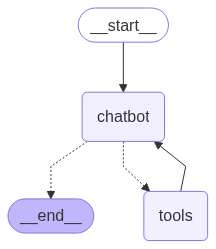

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
print(f"用户输入: {user_task}")

for event in graph.stream({"messages": [HumanMessage(content=user_task)]}):
    for value in event.values():
        if "messages" in value:
            last_message = value["messages"][-1]
            if hasattr(last_message, 'content') and last_message.content:
                print(f"AI响应: {last_message.content}")

用户输入: 请写一个Python代码来验证一维Normal分布的最大似然估计(MLE)公式，使用模拟数据进行验证
AI响应: 好的！我们可以通过以下步骤来验证一维正态分布（Normal Distribution）参数的最大似然估计（MLE）公式：

### 1. 理论MLE公式
对于一组样本 \( x_1, x_2, ..., x_n \) ，正态分布的参数MLE为：
- 均值 \(\mu_{MLE} = \frac{1}{n} \sum_{i=1}^n x_i\)
- 方差 \(\sigma^2_{MLE} = \frac{1}{n} \sum_{i=1}^n (x_i - \mu_{MLE})^2\)

### 2. 验证思路
- 用已知均值和方差生成一组正态分布数据。
- 用MLE公式估计均值和方差。
- 用scipy.stats.norm.fit进行最大似然估计，比较结果。

### 3. Python代码实现
我将为你写好完整代码并运行，展示结果。
AI响应: 文件已成功写入: ./temp/mle_normal_verify.py
AI响应: 错误:
python3: can't open file '/Users/bytedance/Work/agents101/temp/./temp/mle_normal_verify.py': [Errno 2] No such file or directory

返回码: 2

AI响应: 写入文件失败: [Errno 2] No such file or directory: './temp/temp/mle_normal_verify.py'
AI响应: 文件已成功写入: ./temp/mle_normal_verify.py
AI响应: 错误:
python3: can't open file '/Users/bytedance/Work/agents101/temp/./temp/mle_normal_verify.py': [Errno 2] No such file or directory

返回码: 2

AI响应: 代码已为你写好，但由于环境限制，暂时无法直接运行。不过你可以将以下代码复制到本地Python环境中运行，结果会验证MLE公式的正确性。

```python
import nump

## 关于Reasoning model与ReAct框架
现在各厂商提供的"thinking models"或者"reasoning models", (DeepSeek R1, Gemini 2.5 Pro/Flash， o1, o3, Claude 3.7 sonnet)默认会进行一些思考，因此，即使让他直接调用工具，也会先进行一些思考，也和ReAct框架的初衷一致。所以如果用这些模型的话就不用在system prompt里面提醒模型要先思考，但是让他输出一些思考过程利于我们debug。

### React Agent实现方式对比

我们演示了四种不同的React Agent实现方式：

| 方式 | 复杂度 | 灵活性 | 适用场景 | 开发速度 |
|------|--------|--------|----------|----------|
| 手动实现 - Acting Only | 低 | 高 | 简单快速任务 | 快 |
| 手动实现 - Reasoning+Acting | 低 | 高 | 需要debug，调整prompt，复杂任务 | 快 |
| LangGraph - create_react_agent | 中等 | 中等 | 完整ReactAgent循环 | 中等 |
| LangGraph - 图结构 | 高 | 很高 | 复杂工作流 | 慢 |

### 实现方式说明

#### 手动实现（方式1和2）
这两种方式主要演示了AI如何响应工具调用指令：
- **Acting Only**：直接调用工具，输出简洁
- **Reasoning + Acting**：先推理后行动，输出可解释

这些方式适合理解基本原理。

#### LangGraph实现（方式3和4）
这两种方式提供了完整的React Agent功能：
- **create_react_agent**：预构建，支持完整的推理-行动-观察循环
- **图结构**：自定义流程，支持复杂的多步骤工作流

### 最佳实践建议

#### 1. 选择合适的实现方式
- **快速原型**：使用`create_react_agent`
- **生产环境**：根据复杂度选择图结构或预构建agent
- **复杂工作流**：使用图结构方式

#### 2. 工具设计原则
- **单一职责**：每个工具只做一件事
- **清晰文档**：提供详细的docstring和使用完整的类型提示
- **错误处理**：工具应该优雅地处理错误

#### 3. 性能优化
- **缓存机制**：对重复工具调用结果进行缓存
- **并行执行**：独立工具调用可以并行执行
- **提前终止**：设置合理的最大步数限制

#### 4. 调试和监控
- **推荐使用LangSmith来监控模型行为**

### 总结

根据上面的表格，依据需求的复杂度选择合适的实现方式。
